In [55]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '..')


# Import our functions
from moment_conversion import *
from ssid import *
from simulate import *
from real_data_utils import crossval_split

# Import other things that might be useful
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import subspace_angles
import scipy.io as sio
from glmhmm import glm
from glmhmm.analysis import reshape_obs
from real_data_utils import permute_states

# Formatting
colors = np.array([[95,59,151],[85,180,103],[250,186,63],[150,150,150],[0,0,0]])/255

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# set plot design features
font = {'family'   : 'sans-serif',
        'sans-serif' : 'Helvetica',
        'weight'   : 'regular',
        'size'     : 12}

mpl.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load data

In [2]:
y = np.load('../data/real-data/d2mice_outputs.npy')
y = 1-np.nonzero(y)[1][np.newaxis].T
inputs = np.load('../data/real-data/d2mice_inputs.npy')

#### best-LDS recovered system parameters for chosen combination of p and m

In [3]:
q = y.shape[1] # number of observation dimensions
k = 30 # pick sufficiently large hankel size
p = 3
m = 4
u = np.hstack((inputs[:,0:2],inputs[:,-2:]))

# moment conversion
y_reshaped = future_past_Hankel_order_stream(y, k, q).T
u_reshaped = future_past_Hankel_order_stream(u, k, m).T
mu_zs, mu_us, sigma_zz, sigma_uu, sigma_zu = fit_mu_sigma_bernoulli_driven(y_reshaped, u_reshaped)

# rearrange sigma, get estimate of covariance w 
sigma_zz_full = tril_to_full(sigma_zz, 2 * k * q)
sigma_what = get_sigmaw_driven(sigma_uu, sigma_zz_full, sigma_zu)

# cholesky decompose R
R = get_R(sigma_what)

# run n4sid
Ahat,Bhat,Chat,Dhat,Qhat,Rhat,Shat,ss = driven_n4sid(R,k,m,p,q)

#### show recovered parameters comparison for bestLDS vs bestLDS+EM

Text(0.5, 0.98, 'Input-Output Interactions Matrix $D$')

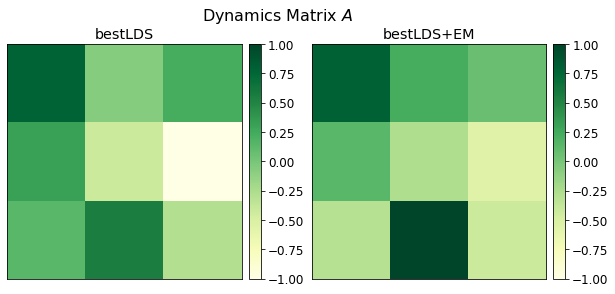

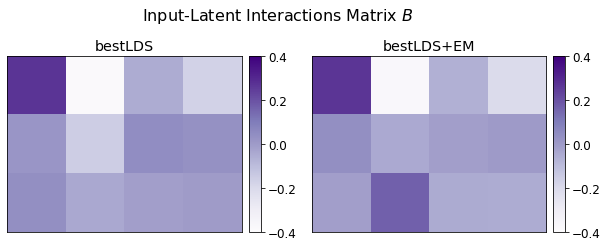

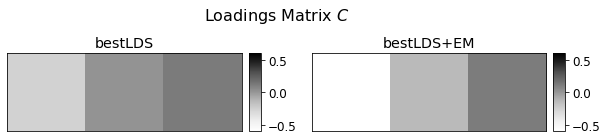

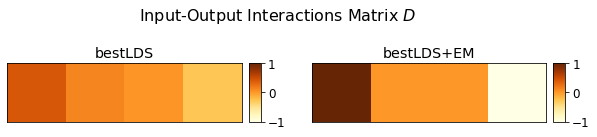

In [79]:
# load parameters
params_EM = sio.loadmat('../data/real-data/bestLDS-EM-real-data.mat')['results']
A_EM = params_EM['params'][0][0][0]['As'][0][:,:,-1]
B_EM = params_EM['params'][0][0][0]['Bs'][0][:,:,-1]
C_EM = params_EM['params'][0][0][0]['Cs'][0][:,:,-1]
D_EM = params_EM['params'][0][0][0]['Ds'][0][:,:,-1]

A_EM, B_EM, C_EM, D_EM = permute_states(A_EM, B_EM, C_EM, D_EM, [0,2,1])

######## plot results for A #############
plt.figure(figsize=(10, 4.5))
ax1 = plt.subplot(1,2,1)
im1 = ax1.imshow(Ahat, vmin=-1, vmax=1, cmap='YlGn')
ax1.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('bestLDS')

ax2 = plt.subplot(1,2,2)
im2 = ax2.imshow(A_EM, vmin=-1, vmax=1, cmap='YlGn')
#plt.colorbar()
ax2.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('bestLDS+EM')

plt.suptitle('Dynamics Matrix $A$', fontsize=16)

######## plot results for B #############
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1,2,1)
im1 = ax1.imshow(Bhat, vmin=-0.4, vmax=0.4, cmap='Purples')
ax1.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('bestLDS')

ax2 = plt.subplot(1,2,2)
im2 = ax2.imshow(B_EM, vmin=-0.4, vmax=0.4, cmap='Purples')
#plt.colorbar()
ax2.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('bestLDS+EM')

plt.suptitle('Input-Latent Interactions Matrix $B$', fontsize=16)

######## plot results for C #############
plt.figure(figsize=(10, 2.5))
ax1 = plt.subplot(1,2,1)
im1 = ax1.imshow(Chat, vmin=-0.6, vmax=0.6, cmap='Greys')
ax1.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('bestLDS')

ax2 = plt.subplot(1,2,2)
im2 = ax2.imshow(C_EM, vmin=-0.6, vmax=0.6, cmap='Greys')
#plt.colorbar()
ax2.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('bestLDS+EM')

plt.suptitle('Loadings Matrix $C$', fontsize=16)

######## plot results for D #############
plt.figure(figsize=(10, 2.5))
ax1 = plt.subplot(1,2,1)
im1 = ax1.imshow(Dhat, vmin=-1, vmax=1, cmap='YlOrBr')
ax1.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax, orientation='vertical')
ax1.set_title('bestLDS')

ax2 = plt.subplot(1,2,2)
im2 = ax2.imshow(D_EM, vmin=-1, vmax=1, cmap='YlOrBr')
#plt.colorbar()
ax2.tick_params(axis='both',which='both',bottom=False,labelbottom=False,left=False,labelleft=False)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im2, cax=cax2, orientation='vertical')
ax2.set_title('bestLDS+EM')

plt.suptitle('Input-Output Interactions Matrix $D$', fontsize=16)

#### Impulse Response plots

In [108]:
def generate_response(A,B,C,D,ugen):
    x0 = np.zeros(q)
    d = np.zeros(q)
    x0 = np.zeros(q)
    muu = np.zeros(2) # don't actually matter but are required inputs for this function
    Qu = np.eye(2) # don't actually matter but are required inputs for this function
    ygen,xgen,_,_,_ = simulate_driven_noiseless_bernoulli_lds(len(y),x0,A,B,C,D,d,muu,Qu,inputs=ugen)
    zs = []
    for i in range(50):
        zs.append(Chat @ xgen[i, :] + Dhat @ ugen[i,:])
        
    return zs

# cues
ugen = np.zeros_like(u)
ugen[0,0] = 1
cues_bestLDS = generate_response(Ahat,Bhat,Chat,Dhat,ugen)
cues_EM = generate_response(A_EM,B_EM,C_EM,D_EM,ugen)

# previous choice
ugen = np.zeros_like(u)
ugen[0,1] = 1
choice_bestLDS = generate_response(Ahat,Bhat,Chat,Dhat,ugen)
choice_EM = generate_response(A_EM,B_EM,C_EM,D_EM,ugen)

# previous rewarded choice
ugen = np.zeros_like(u)
ugen[0,2] = 1
rewchoice_bestLDS = generate_response(Ahat,Bhat,Chat,Dhat,ugen)
rewchoice_EM = generate_response(A_EM,B_EM,C_EM,D_EM,ugen)

# laser
ugen = np.zeros_like(u)
ugen[0,3] = 1
laser_bestLDS = generate_response(Ahat,Bhat,Chat,Dhat,ugen)
laser_EM = generate_response(A_EM,B_EM,C_EM,D_EM,ugen)

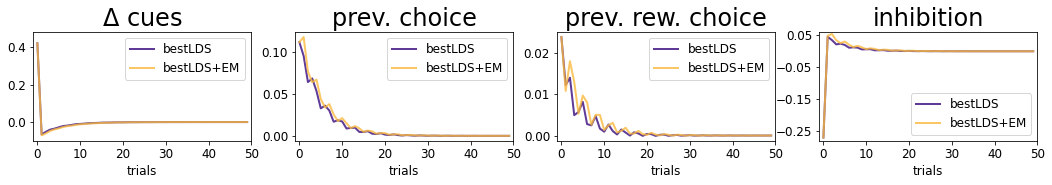

In [110]:
plt.figure(figsize=(18,2))

plt.subplot(1,4,1)
plt.plot(cues_bestLDS, color=colors[0], linewidth=2, label='bestLDS')
plt.plot(cues_EM, color=colors[2], alpha=0.8, linewidth=2, label='bestLDS+EM')
plt.xlim([-1, 50])
plt.title('$\Delta$ cues', fontsize=24)
plt.xlabel('trials')
plt.ylim([-0.1,0.48])
plt.yticks(np.arange(-0,0.51,0.2))
plt.legend()


plt.subplot(1,4,2)
plt.plot(choice_bestLDS, color=colors[0], linewidth=2, label='bestLDS')
plt.plot(choice_EM, color=colors[2], alpha=0.8, linewidth=2, label='bestLDS+EM')
plt.xlim([-1, 50])
plt.title('prev. choice', fontsize=24)
plt.xlabel('trials')
plt.yticks(np.arange(0,0.11,0.05))
plt.legend()

plt.subplot(1,4,3)
plt.plot(rewchoice_bestLDS, color=colors[0], linewidth=2, label='bestLDS')
plt.plot(rewchoice_EM, color=colors[2], alpha=0.8, linewidth=2, label='bestLDS+EM')
plt.xlim([-1, 50])
plt.title('prev. rew. choice', fontsize=24)
plt.xlabel('trials')
plt.yticks(np.arange(0,0.025,0.01))
plt.legend()

plt.subplot(1,4,4)
plt.plot(laser_bestLDS, color=colors[0], linewidth=2, label='bestLDS')
plt.plot(laser_EM, color=colors[2], alpha=0.8, linewidth=2, label='bestLDS+EM')
plt.xlim([-1, 50])
plt.title('inhibition', fontsize=24)
plt.xlabel('trials')
plt.yticks(np.arange(-0.25,0.06,0.1))
plt.ylim([-0.28,0.06])
plt.legend()

#plt.savefig('saved_images/fig5e.pdf', transparent=True)